
# 01 Introduction to Entropy and Decision Trees

Entropy is the main metric to quantify information that is represented in a specific class/variable or dataset. To be as least abstract as possible so everyone can understand the concept easily, we rely on a well known example. Under [github](https://gist.github.com/ompramod2199/eb701dd4ac3ae6d4897af6ad52f8e412#file-tennis_play-csv) you can find a dataset, that tells us about the decision making process of a tennis player. Let's have a closer look at the data.

In [2]:
import pandas as pd

# Load dataset directly from GitHub Gist (raw link)
url = "https://gist.githubusercontent.com/ompramod2199/eb701dd4ac3ae6d4897af6ad52f8e412/raw/tennis_play.csv"

# Read CSV
df = pd.read_csv(url)

df.describe()

,outlook,temp,humidity,windy,play
count,14,14,14,14,14
unique,3,3,2,2,2
top,sunny,mild,high,False,yes
freq,5,6,7,8,9


There are four inputs with `outlook`, `temp`, `humidity` and `windy`. These inputs should have a relation to the output `play`. Now that we have an overview, we can easily calculate how much information is within each of the inputs and outputs.

Entropy:

$H(D)=-\Sigma_{f \in D} \; p(f) log_2(p(f))$

* with H as the entropy
* with D as the given data
* with f as one of the discrete state of information within the data
* with p(f) as the propability of f in D

In [3]:
import numpy as np

# Function to calculate entropy
def entropy(series):
    probs = series.value_counts(normalize=True)  # probabilities of each category
    return -np.sum(probs * np.log2(probs))

# Calculate entropy for each column
entropy_values = {col: entropy(df[col]) for col in df.columns}

# Display results
for col, ent in entropy_values.items():
    print(f"Entropy of {col}: {ent:.2f}")

Entropy of outlook: 1.58
Entropy of temp: 1.56
Entropy of humidity: 1.00
Entropy of windy: 0.99
Entropy of play: 0.94


#### TASK: Try to answer the following questions for yourself by discussing it with a collegue.


*   Why it the entropy of outlook and temp higher than 1?
*   What does it mean when the entropy of a binary class is 1?



Since we know the entropy of each input/output or feature, we are now having a look at the decision tree structure. Let's assume we want decide, whether we want go for a game of tennis or not. Therefore the output of the decision tree would be the column `play`. The inputs would be all other columns (`outlook`, `temp`, `humidity` and `windy`). Strings are not well suited for a decision tree. Therefore we need to transform/encode them with numbers (integers)

In [4]:
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding to all columns
encoder = LabelEncoder()
df_encoded = df.apply(encoder.fit_transform)

# Split into X and y
X = df_encoded.drop(columns=["play"])
y = df_encoded["play"]
print(df.head(5))
print(df_encoded.head(5))

    outlook  temp humidity  windy play
0     sunny   hot     high  False   no
1     sunny   hot     high   True   no
2  overcast   hot     high  False  yes
3     rainy  mild     high  False  yes
4     rainy  cool   normal  False  yes
   outlook  temp  humidity  windy  play
0        2     1         0      0     0
1        2     1         0      1     0
2        0     1         0      0     1
3        1     2         0      0     1
4        1     0         1      0     1


Before we go into the design of a tree, we have a close look at the informaition gain. The information gain tells us something about the importance of a specific feature. So let's compute the information gain for each feature.

We start with outlook as it is the first column:

We know that the entropy of the output class (play) is 0.94. The information gain tells us about how much entropy we lose if we go to use a specific feature as our deciding criterion. Since we decided to go for `outlook` first, we can split the data according to the unique values within outlook.

Since `outlook` has three unique values we expect three subsets

In [5]:
# Split play based on unique values in outlook
outlook_groups = {val: df[df["outlook"] == val]["play"] for val in df["outlook"].unique()}

# Show results
for outlook_val, plays in outlook_groups.items():
    print(f"\nPlay values when outlook = {outlook_val}:")
    print(plays.reset_index(drop=True))


Play values when outlook = sunny:
0     no
1     no
2     no
3    yes
4    yes
Name: play, dtype: object

Play values when outlook = overcast:
0    yes
1    yes
2    yes
3    yes
Name: play, dtype: object

Play values when outlook = rainy:
0    yes
1    yes
2     no
3    yes
4     no
Name: play, dtype: object


Just by observing the results we see that for our three unique values for the feature `outlook`, we get three results. For these three results we can calculate the entropy.

In [6]:
# Calculate entropy of 'play' for each unique outlook value
entropies = {}
for val in df["outlook"].unique():
    subset = df[df["outlook"] == val]["play"]
    entropies[val] = entropy(subset)

# Display results
for outlook_val, ent in entropies.items():
    print(f"Entropy of play when outlook = {outlook_val}: {ent:.4f}")

Entropy of play when outlook = sunny: 0.9710
Entropy of play when outlook = overcast: -0.0000
Entropy of play when outlook = rainy: 0.9710


Now we can calculate the information gain from the results by using the equation:

$IG(D,a)=H(D)-H(D|a)$

with $IG(D,a)$ beeing the information gain and
with $H(D|a)$ beeing the conditional entropy:

$H(D|a) = -\Sigma_{v \in values(f)} \; \frac{|S_a(v)|}{|D|} \; H(S_a(v))$

* with v as one of the unique values of a
* with $S_a(v)$ as the given subset split with v

As alwaly, let's have a look at an example, so we better understand what is going on.

In [7]:
# Overall entropy of play
H_play = entropy(df["play"])

# Conditional entropy for outlook
H_cond = 0
for val in df["outlook"].unique():
    subset = df[df["outlook"] == val]["play"]
    weight = len(subset) / len(df)
    H_cond += weight * entropy(subset)

# Information gain
IG_outlook = H_play - H_cond

print(f"Entropy of Play: {H_play:.2f}")
print(f"Conditional Entropy given Outlook: {H_cond:.2f}")
print(f"Information Gain (Outlook): {IG_outlook:.2f}")

Entropy of Play: 0.94
Conditional Entropy given Outlook: 0.69
Information Gain (Outlook): 0.25


Additionally we can directly see above, that for `outlook` == overcast, we directly have an entropy of 0, which means the tree would end there in a leaf node.

Now we can compare the information gain with all other information gains of all other features.

In [8]:
# Conditional entropy for temp
H_cond_temp = 0
for val in df["temp"].unique():
    subset = df[df["temp"] == val]["play"]
    weight = len(subset) / len(df)
    H_cond_temp += weight * entropy(subset)

# Conditional entropy for humidity
H_cond_humidity = 0
for val in df["humidity"].unique():
    subset = df[df["humidity"] == val]["play"]
    weight = len(subset) / len(df)
    H_cond_humidity += weight * entropy(subset)

# Conditional entropy for windy
H_cond_windy = 0
for val in df["windy"].unique():
    subset = df[df["windy"] == val]["play"]
    weight = len(subset) / len(df)
    H_cond_windy += weight * entropy(subset)

# Information gain
IG_temp = H_play - H_cond_temp
IG_humidity = H_play - H_cond_humidity
IG_windy = H_play - H_cond_windy

print(f"Entropy of Play: {H_play:.2f}")
print(f"Conditional Entropy given Outlook: {H_cond:.2f}")
print(f"Information Gain (Outlook): {IG_outlook:.2f}")
print(f"Conditional Entropy given temp: {H_cond_temp:.2f}")
print(f"Information Gain (temp): {IG_temp:.2f}")
print(f"Conditional Entropy given Humidity: {H_cond_humidity:.2f}")
print(f"Information Gain (Humidity): {IG_humidity:.2f}")
print(f"Conditional Entropy given windy: {H_cond_windy:.2f}")
print(f"Information Gain (windy): {IG_windy:.2f}")

Entropy of Play: 0.94
Conditional Entropy given Outlook: 0.69
Information Gain (Outlook): 0.25
Conditional Entropy given temp: 0.91
Information Gain (temp): 0.03
Conditional Entropy given Humidity: 0.79
Information Gain (Humidity): 0.15
Conditional Entropy given windy: 0.89
Information Gain (windy): 0.05


Comparing the information gain of each feature it is clear that the most important feature, and therefore also the first feature in the decision tree should be `outlook` with an information gain of 0.25

#### TASK: Try to answer the following questions for yourself by discussing it with a colleague.

*   What should be the next internal note, knowing that the first node will check for `outlook`==overcast (or a numerical representation)?
*   Why is the information gain that important for the creation of decision trees?


Now, Let's see if the calculation above are true for the tree.

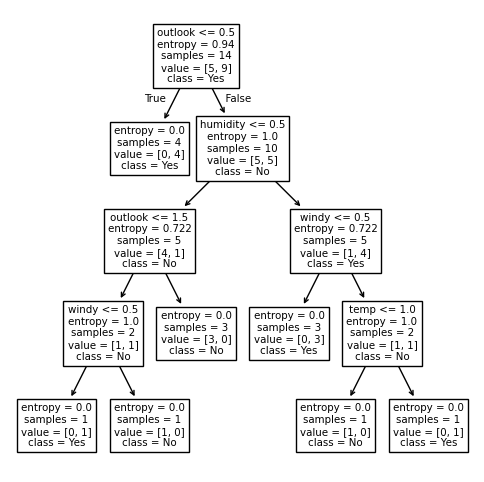

In [ ]:
from sklearn import tree
from matplotlib import pyplot as plt

#build decision tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4,min_samples_leaf=1)
#max_depth represents max level allowed in each tree, min_samples_leaf minumum samples storable in leaf node

#fit the tree to the tennis dataset
clf.fit(X,y)

#plot decision tree
fig, ax = plt.subplots(figsize=(6, 6)) #figsize value changes the size of plot
#tree.plot_tree(clf,ax=ax,feature_names=['What input was used?','What input was used?','What input was used?','What input was used?'])
tree.plot_tree(clf,ax=ax,feature_names=X.columns,class_names=['No','Yes'])
#
plt.show()

The order of feature importance seems to be:
*    outlook
*    humidity
*    windy
*    temp